# Data Analytics —— Aqumon's Basic Idea

## Downloading the data —— From YahooFinance

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
import pandas as pd
import datetime
import yfinance as yf
import backtrader as bt
import numpy as np

# Date range
start = '2010-01-01'
end = '2020-03-25'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'NBL', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'DHR',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'SPY']
assets.sort()

# Downloading data
prices = yf.download(assets, start = start, end = end)
prices = prices.dropna()

[*****************     36%                       ]  9 of 25 completed

In [2]:
display(prices.head())

Adj Close                                                         \
                  APA        BAX        BMY      CMCSA        CNP        CPB   
Date                                                                           
2013-05-09  70.188889  34.012135  32.416080  18.683704  17.539644  36.634739   
2013-05-10  71.791328  33.901943  32.870701  18.735893  17.627014  36.817665   
2013-05-13  71.748260  33.758209  33.236015  18.783733  17.532366  36.913120   
2013-05-14  71.532867  33.772587  34.267044  18.844629  17.721104  37.891426   
2013-05-15  70.550728  33.801338  35.996227  19.018589  17.926741  38.289108   

                                                       ...     Volume  \
                   DE        DHR       HPQ        JCI  ...        NBL   
Date                                                   ...              
2013-05-09  77.665771  30.609207  7.688656  24.590776  ...  3872800.0   
2013-05-10  77.758423  30.688530  7.819343  24.525614  ...  2393600.0   
2013-05-13  77.994331  30.539806  7.750371  24.518370  ...  1951400.0   
2013-05-14  78.996857  30.663750  7.812084  24.699392  ...  2163200.0   
2013-05-15  75.517540  30.767855  7.612425  24.728352  ...  3296400.0   

                                                                     \
                    NI       PCAR       PSA        SEE          SPY   
Date                                                                  
2013-05-09  10011000.0  1664200.0  494200.0  1388000.0  106738600.0   
2013-05-10   9398100.0  1287300.0  502000.0  2977300.0  103203000.0   
2013-05-13   7381500.0  1350600.0  445100.0  1327500.0   81843200.0   
2013-05-14  11778700.0  1686400.0  460400.0  2077100.0  119000900.0   
2013-05-15  11043700.0  1629200.0  773900.0  1934200.0  120718500.0   

                                                        
                  TGT        TXT         VZ       ZION  
Date                                                    
2013-05-09  3659000.0  1814000.0  7379300.0  1225500.0  
2013-05-10  3995100.0  1979200.0  6242100.0   838800.0  
2013-05-13  2877100.0  2538800.0  5347700.0  1729200.0  
2013-05-14  3773500.0  2447900.0  7397700.0  1470500.0  
2013-05-15  5177000.0  1589500.0  9204900.0  2333000.0  

[5 rows x 150 columns]

## Building the Backtest Function with Backtrader

### Defining Backtest Function

In [3]:
def backtest(datas, strategy, plot=False, **kwargs):
    cerebro = bt.Cerebro()
    cerebro.broker.setcommission(commission=0.005)
    for data in datas:
        cerebro.adddata(data)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    results = cerebro.run(stdstats=False)
    if plot:
        cerebro.plot(iplot=True, start=1004, end=3000)
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

### Building Data Feeds for Backtesting

In [4]:
# Creating Assets bt.feeds
assets_prices = []
for i in assets:
    if i != 'SPY':
        prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), i)].dropna()
        prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
        assets_prices.append(bt.feeds.PandasData(dataname=prices_, plot=False))

# Creating Benchmark bt.feeds        
prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), 'SPY')].dropna()
prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
benchmark = bt.feeds.PandasData(dataname=prices_, plot=False)

display(prices_.head())

,Close,High,Low,Open,Volume
Date,,,,,
2013-05-09,162.880005,163.699997,162.470001,163.270004,106738600.0
2013-05-10,163.410004,163.550003,162.509995,162.990005,103203000.0
2013-05-13,163.539993,163.809998,162.820007,163.199997,81843200.0
2013-05-14,165.229996,165.350006,163.669998,163.669998,119000900.0
2013-05-15,166.119995,166.449997,164.910004,164.960007,120718500.0


## Building Strategies with Backtrader

### Rebalancing Quarterly using Riskfolio-Lib

In [5]:
pd.options.display.float_format = '{:.4%}'.format

data = prices.loc[:, ('Adj Close', slice(None))]
data.columns = assets
data = data.drop(columns=['SPY']).dropna()
returns = data.pct_change().dropna()
display(returns.head())

,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,HPQ,JCI,...,MSFT,NBL,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-10,2.2830%,-0.3240%,1.4025%,0.2793%,0.4981%,0.4993%,0.1193%,0.2591%,1.6997%,-0.2650%,...,0.0919%,-1.0603%,-0.3813%,-0.1519%,-0.2126%,1.5831%,0.3742%,0.3328%,0.3415%,0.5382%
2013-05-13,-0.0600%,-0.4240%,1.1114%,0.2553%,-0.5370%,0.2593%,0.3034%,-0.4846%,-0.8821%,-0.0295%,...,1.0401%,0.7580%,0.1044%,-0.3422%,0.6574%,-1.0823%,0.0865%,0.0737%,-0.6429%,1.1855%
2013-05-14,-0.3002%,0.0426%,3.1021%,0.3242%,1.0765%,2.6503%,1.2854%,0.4058%,0.7963%,0.7383%,...,2.2256%,1.6948%,1.1123%,0.9155%,-0.4294%,1.4880%,0.0000%,0.6262%,1.1798%,2.2676%
2013-05-15,-1.3730%,0.0851%,5.0462%,0.9231%,1.1604%,1.0495%,-4.4044%,0.3395%,-2.5558%,0.1172%,...,0.9544%,0.3231%,1.9251%,0.9296%,1.5367%,0.6037%,1.3681%,1.0615%,0.8088%,-0.3326%
2013-05-16,-1.2212%,1.8427%,-3.5408%,-1.9666%,-1.2700%,-0.6024%,-0.2789%,0.3384%,1.8598%,-0.7028%,...,0.6795%,-0.1440%,-0.4722%,-0.8082%,-1.1784%,1.2430%,-0.5541%,-0.0362%,-0.7463%,-0.4449%


In [6]:
# Selecting Dates for Rebalancing

# Selecting last day of month of available data
index = returns.groupby([returns.index.year, returns.index.month]).tail(1).index
index_2 = returns.index

# Quarterly Dates
index = [x for x in index if float(x.month) % 3.0 == 0 ] 

# Dates where the strategy will be backtested
index_ = [index_2.get_loc(x) for x in index if index_2.get_loc(x) > 1000]

In [7]:
# Building Constraints

asset_classes = {'Assets': ['JCI','TGT','CMCSA','CPB','MO','NBL','APA','MMC',
                            'JPM','ZION','PSA', 'BAX','BMY','LUV','PCAR',
                            'TXT','DHR','DE','MSFT','HPQ','SEE','VZ','CNP','NI'], 
                 'Industry': ['Consumer Discretionary','Consumer Discretionary',
                              'Consumer Discretionary', 'Consumer Staples',
                              'Consumer Staples','Energy','Energy','Financials',
                              'Financials','Financials', 'Health Care',
                              'Health Care','Health Care','Industrials','Industrials',
                              'Industrials','Industrials','Industrials',
                              'Information Technology','Information Technology',
                              'Materials','Telecommunications Services','Utilities',
                              'Utilities'] }

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False],
               'Type': ['All Assets', 'All Classes', 'All Classes'],
               'Set': ['', 'Industry', 'Industry'],
               'Position': ['', '', ''],
               'Sign': ['<=', '<=', '>='],
               'Weight': [0.10, 0.20, 0.03],
               'Type Relative': ['', '', ''],
               'Relative Set': ['', '', ''],
               'Relative': ['', '', ''],
               'Factor': ['', '', '']}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,<=,10.0000%,,,,
1,False,All Classes,Industry,,<=,20.0000%,,,,
2,False,All Classes,Industry,,>=,3.0000%,,,,


In [9]:
import riskfolio.ConstraintsFunctions as cf

A, B = cf.assets_constraints(constraints, asset_classes)
# Building a bucle that estimate optimal portfolios on
# rebalancing dates

import riskfolio.Portfolio as pf

models = {}

# rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
#        'CVaR', 'WR', 'MDD', 'ADD', 'CDaR']

rms = ['MV']

for j in rms:
    
    weights = pd.DataFrame([])

    for i in index_:
        Y = returns[i-1000:i] # taking last 4 years (250 trading days per year)

        # Building the portfolio object
        port = pf.Portfolio(returns=Y)
        
        # Add portfolio constraints
        port.ainequality = A
        port.binequality = B
        
        # Calculating optimum portfolio

        # Select method and estimate input parameters:

        method_mu='hist' # Method to estimate expected returns based on historical data.
        method_cov='hist' # Method to estimate covariance matrix based on historical data.

        port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

        # Estimate optimal portfolio:

        model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
        rm = j # Risk measure used, this time will be variance
        obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
        hist = True # Use historical scenarios for risk measures that depend on scenarios
        rf = 0 # Risk free rate
        l = 0 # Risk aversion factor, only useful when obj is 'Utility'

        w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)
    
    models[j] = weights.copy()
    models[j].index = index_

In [10]:
# Building the Asset Allocation Class

class AssetAllocation(bt.Strategy):

    def __init__(self):

        j = 0
        for i in assets:
            setattr(self, i, self.datas[j])
            j += 1
        
        self.counter = 0
        
    def next(self):
        if self.counter in weights.index.tolist():
            for i in assets:
                w = weights.loc[self.counter, i]
                self.order_target_percent(getattr(self, i), target=w)
        self.counter += 1

<IPython.core.display.Javascript object>


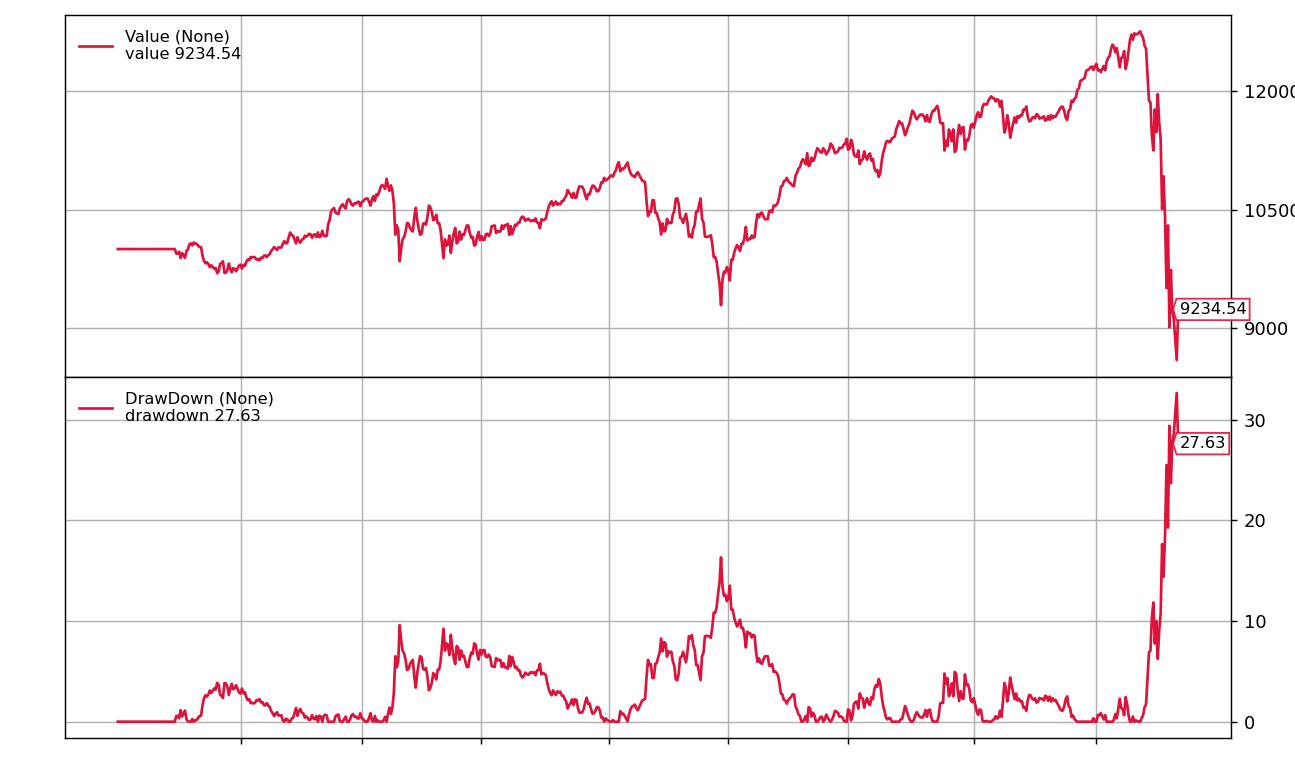

In [11]:
# Backtesting Mean Variance Strategy

assets = returns.columns.tolist()
weights = models['MV']

dd, cagr, sharpe = backtest(assets_prices, AssetAllocation, plot=True)
# print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")


In [14]:
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")

Max Drawdown: 32.67%
CAGR: -1.15%
Sharpe: -0.008


<IPython.core.display.Javascript object>


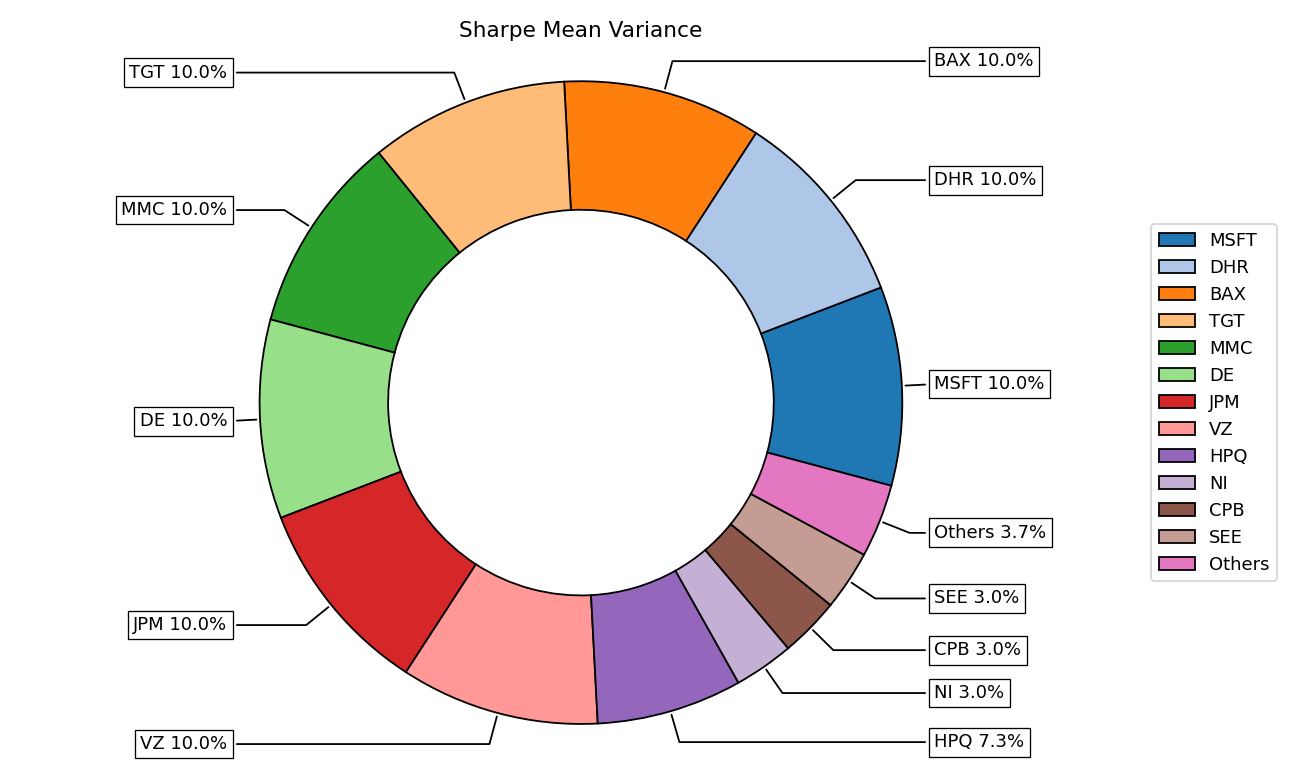

In [12]:
import riskfolio.PlotFunctions as plf

# Plotting the composition of the last portfolio

w = pd.DataFrame(models['MV'].iloc[-1,:])
ax = plf.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

In [13]:
# Composition per Industry

w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)
w_classes = w_classes.groupby(['Industry']).sum()
w_classes.columns = ['weights']
display(w_classes)

,weights
Industry,
Consumer Discretionary,10.6796%
Consumer Staples,3.0000%
Energy,3.0000%
Financials,20.0000%
Health Care,10.0000%
Industrials,20.0000%
Information Technology,17.3204%
Materials,3.0000%
Telecommunications Services,10.0000%
